# Customer's Feedback Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re

import pymongo

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
    
from wordcloud import WordCloud,STOPWORDS 
from matplotlib import rcParams
from collections import Counter


# SETTING
plt.style.use('ggplot')
#display maximum column and rows
pd.options.display.max_columns = 999
pd.options.display.min_rows = 999
pd.options.display.max_colwidth = 999
stopword = STOPWORDS
stopword.add('im')
stopword.add('youre')


red = '#ef4b4b'
black = '#584b42'
green = '#a0cc78'
yellow_ = '#f6d365'
blue_ = '#49beb7'

#INIT
vader = SentimentIntensityAnalyzer()


#METHODS
def sep():
    print(100*'-')

def connectMongoDB(dbname):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[dbname]
    return db

dbname = 'clothing_fit'
db = connectMongoDB(dbname)

In [2]:
rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)
df_rent

# MENGECEK NULL
df_rent.isnull().sum()
# df_rent.info()

_id                     0
fit                     0
user_id                 0
bust size            1901
item_id                 0
weight               3161
rating                  0
rented for              0
review_text             0
body type            1510
review_summary          0
category                0
height                 76
size                    0
age                   103
review_date             0
sentiment_              0
height_cm               0
weight_kg            3161
age_                    0
review_date_            0
sentiment_summary       0
sentiment_text          0
dtype: int64

## FEEDBACK :
    - rating
    - review
    - fit

In [3]:
df_rent.fit.isnull().sum()

0

In [4]:
df_rent.review_text.isnull().sum()

0

In [5]:
df_rent.rating.isnull().sum()

0

### Handling Null pada kolom rating

In [6]:
print(df_rent.rating.mode())
print(df_rent.rating.mean())
print(df_rent.rating.quantile(0.5))

0    10.0
dtype: float64
9.091925900034953
10.0


Keterangan :
- untuk kolom rating ini ternyata memiliki median, dan modus dengan angka sempurna -> 10
- bahkan rata-rata rating dari semua data yang ada juga mencapai 9
- kemungkinan fillna akan diisi oleh salah satu nilai dari modus, median, atau meannya ini

Untuk itu, coba dilihat lagi 3 data ini pada kolom feedback yang lainnya, yaitu kolom review dan kolom fit

In [7]:
df_rent[df_rent['rating'].isnull()][['fit','sentiment_', 'review_summary', 'review_text']]

,fit,sentiment_,review_summary,review_text


 3 data rating == null mendapat feedback positif sempurna
#### sehingga fillna akan diisi dengan rating angka sempurna

In [8]:
x = df_rent[df_rent['rating'].isnull()].copy()

In [9]:
# mereplace null dengan angka 10 -> modus dan median + analisa feedback yang positif

x.rating = x.rating.fillna(10)
print("banyak data : ", len(x))
sep()
print("angka null di rating :")
x['rating'].isnull().sum()

banyak data :  0
----------------------------------------------------------------------------------------------------
angka null di rating :


0

## Update dalam database

In [10]:
# UPDATE DATA DITAMBAH DENGAN DATA weight  transformed
dict_rent_transpose = x.transpose().to_dict()
keys = dict_rent_transpose.keys() 
print("akan update sejumlah : ",len(dict_rent_transpose.keys()))


akan update sejumlah :  0


In [11]:
# UPDATING data di mongodb
for i in keys:
    old = rent[i]
    new = {"$set": dict_rent_transpose[i]}
    db.rentCollection.update_one(old, new)

In [12]:
# MENGECEK HASIL UPDATE

rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)

# MENGECEK NULL
df_rent['rating'].isnull().sum()
# df_rent.info()


0

# Analisa Feedback
---

## Melihat Insight Rating Feedback

In [13]:
df_rent.rating.groupby(df_rent.rating).count()

rating
2.0        88
4.0       321
6.0      1086
8.0      5606
10.0    12926
Name: rating, dtype: int64

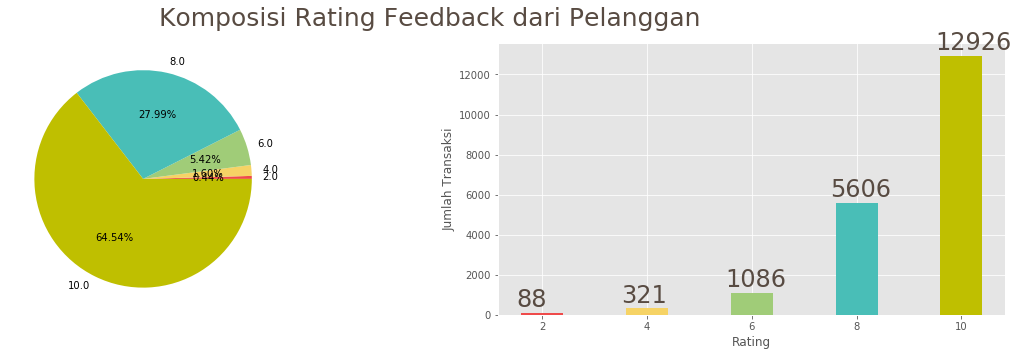

In [14]:
sums = df_rent.rating.groupby(df_rent.rating).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Rating Feedback dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red, yellow_, green, blue_, 'y'] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red, yellow_, green, blue_, 'y'])
for i, v in enumerate(count[:]):
    plt.text((2*i)+1.5,v+300 , str(v), color=black, fontsize='24')
plt.xlabel('Rating')
plt.ylabel('Jumlah Transaksi')

# # ZOOM IN perbandingan sentiment negatif dan netral
# ax = fig.add_axes([0.58,0.4,0.1,0.4])
# plt.bar(index[:2],count[:2], color=[red,black,])
# for i, v in enumerate(count[:2]):
#     plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()


# 64.5 % Transaksi mendapat feedback rating sempurna

##### 28% transaksi cukup baik, 5.5 % netral, dan 2% sisanya mendapat feedback rating yang buruk

#### Dari segi jumlah transaksi, masih ada 409 transaksi mendapat rating rendah, dan 1086 transaksi netral

<hr>

## Melihat Insight Fit Feedback 

In [15]:
df_rent.fit.groupby(df_rent.fit).count()

fit
fit      14651
large     2651
small     2725
Name: fit, dtype: int64

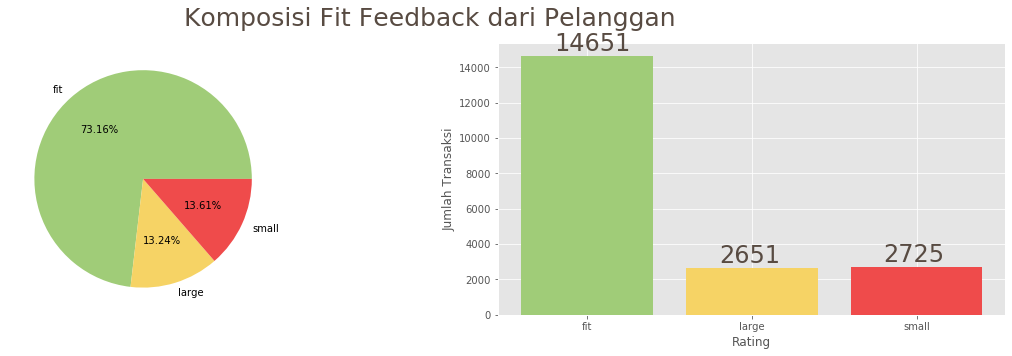

In [16]:
sums = df_rent.fit.groupby(df_rent.fit).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Fit Feedback dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[green, yellow_, red, blue_, 'y'] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[green, yellow_, red, blue_, 'y'])
for i, v in enumerate(count[:]):
    plt.text((i-0.2),v+300 , str(v), color=black, fontsize='24')
plt.xlabel('Rating')
plt.ylabel('Jumlah Transaksi')

# # ZOOM IN perbandingan sentiment negatif dan netral
# ax = fig.add_axes([0.58,0.4,0.1,0.4])
# plt.bar(index[:2],count[:2], color=[red,black,])
# for i, v in enumerate(count[:2]):
#     plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()


## Melihat Insight Sentiment review Feedback 

In [17]:
df_rent.sentiment_.groupby(df_rent.sentiment_).count()

sentiment_
negative      333
neutral       238
positive    19456
Name: sentiment_, dtype: int64

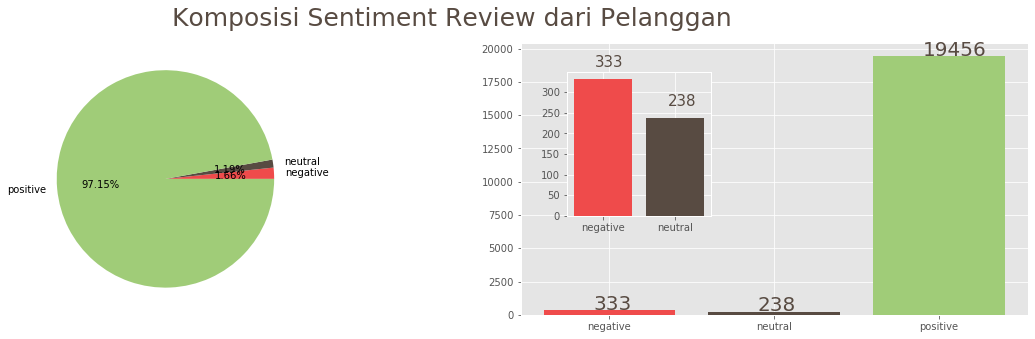

In [18]:
sums = df_rent.sentiment_.groupby(df_rent.sentiment_).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment Review dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green] )

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='20')

# ZOOM IN perbandingan sentiment negatif dan netral
ax = fig.add_axes([0.58,0.4,0.1,0.4])
plt.bar(index[:2],count[:2], color=[red,black,])
for i, v in enumerate(count[:2]):
    plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()
# sums

## Melihat Insight Sentiment Review Summary Feedback

In [19]:
df_rent.sentiment_summary.groupby(df_rent.sentiment_summary).count()

sentiment_summary
negative      519
neutral      3006
positive    16502
Name: sentiment_summary, dtype: int64

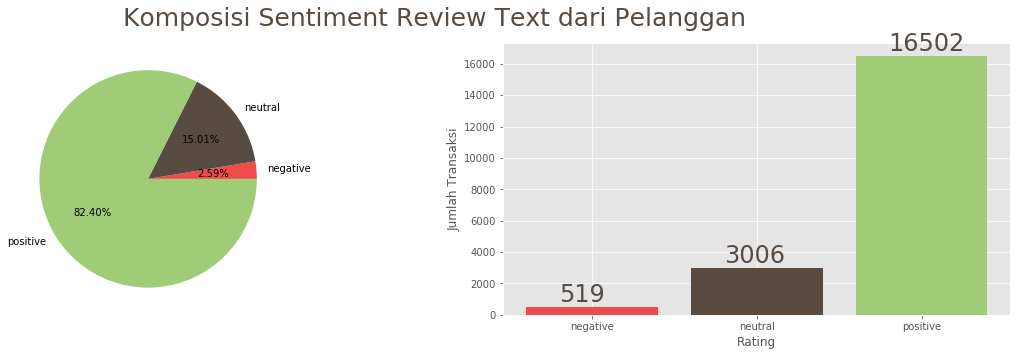

In [20]:
sums = df_rent.sentiment_summary.groupby(df_rent.sentiment_summary).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment Review Text dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green])

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text((i-0.2),v+300 , str(v), color=black, fontsize='24')
plt.xlabel('Rating')
plt.ylabel('Jumlah Transaksi')

# # ZOOM IN perbandingan sentiment negatif dan netral
# ax = fig.add_axes([0.58,0.4,0.1,0.4])
# plt.bar(index[:2],count[:2], color=[red,black,])
# for i, v in enumerate(count[:2]):
#     plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()


## Melihat Insight Sentiment Review Text Feedback

In [21]:
df_rent.sentiment_text.groupby(df_rent.sentiment_text).count()

sentiment_text
negative      693
neutral       525
positive    18809
Name: sentiment_text, dtype: int64

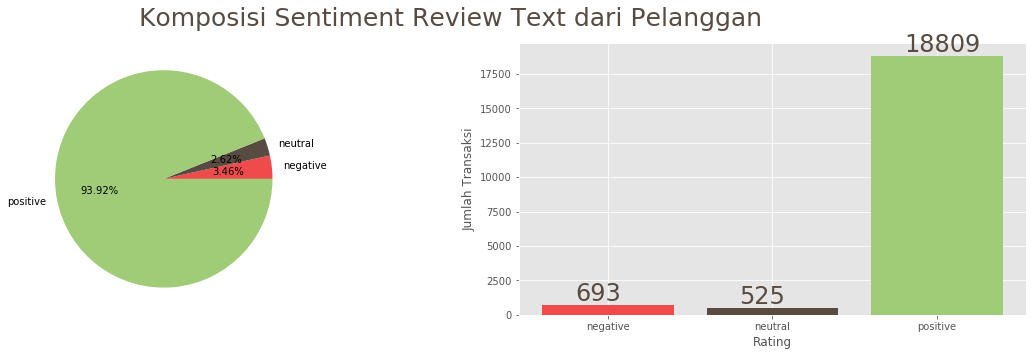

In [22]:
sums = df_rent.sentiment_text.groupby(df_rent.sentiment_text).count()
sums

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Sentiment Review Text dari Pelanggan', fontsize='25', color=black)

plt.subplot(121)
plt.pie(sums, labels=sums.index, autopct='%1.2f%%',colors=[red,black,green])

plt.subplot(122)
index = sums.index
count = sums.tolist()

plt.bar(index[:],count[:], color=[red,black,green])
for i, v in enumerate(count[:]):
    plt.text((i-0.2),v+300 , str(v), color=black, fontsize='24')
plt.xlabel('Rating')
plt.ylabel('Jumlah Transaksi')

# # ZOOM IN perbandingan sentiment negatif dan netral
# ax = fig.add_axes([0.58,0.4,0.1,0.4])
# plt.bar(index[:2],count[:2], color=[red,black,])
# for i, v in enumerate(count[:2]):
#     plt.text(i - 0.1,v + 30 , str(v), color=black, fontsize='15')
plt.show()


Dalam data sementara ini, feedback customer cukup baik. 97% memberikan review positif, 73% memberikan feedback “fit”, dan 64% memberikan rating 10.  

#### Berapa prosentase yang 100% memberi feedback sempurna ?
#### Dan bagaimana kondisi sisanya ? apa yang bisa diperbaiki lagi ?


<hr>

In [23]:
df_perfect = df_rent[df_rent['rating']==10][df_rent['fit']=='fit'][df_rent['sentiment_']=='positive']
df_perfect.shape

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(10355, 23)

In [24]:
df_worst = df_rent[df_rent['rating']<6][df_rent['fit']!='fit'][df_rent['sentiment_']!='positive']
df_worst.shape

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(92, 23)

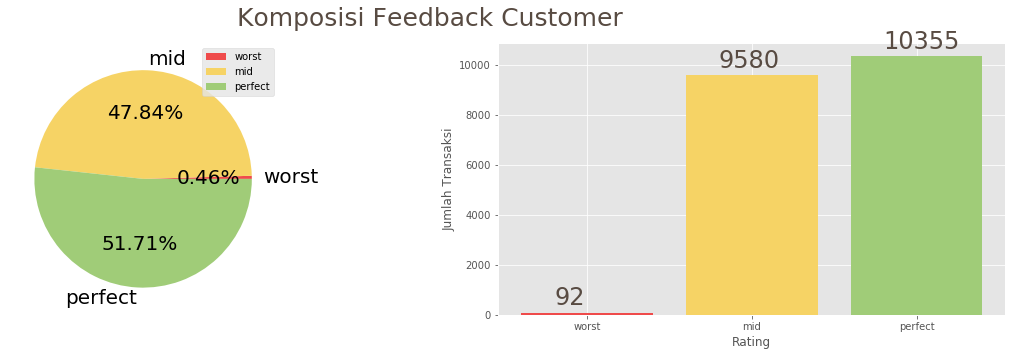

In [29]:
mid = df_rent.shape[0]-df_perfect.shape[0]-df_worst.shape[0]
top = df_perfect.shape[0]
low = df_worst.shape[0]

fig = plt.figure(figsize=(20,5))
plt.suptitle('Komposisi Feedback Customer', fontsize='25', color=black)

plt.subplot(121)
plt.pie([low, mid, top], labels=['worst', 'mid', 'perfect'], autopct='%1.2f%%',colors=[red,yellow_,green], textprops={'fontsize': 20})

plt.legend()

plt.subplot(122)
index = ['worst', 'mid', 'perfect']
count = [low, mid, top]

plt.bar(index[:],count[:], color=[red,yellow_,green])
for i, v in enumerate(count[:]):
    plt.text((i-0.2),v+300 , str(v), color=black, fontsize='24')
plt.xlabel('Rating')
plt.ylabel('Jumlah Transaksi')

plt.show()

### berdasarkan data, sebesar 51.7% transaksi telah mendapat feedback yang sempurna. Yang benar-benar merasa tidak puas hanya ada 0.46%. Sedangkan 47.8% sisanya bermacam-macam feedback.